<a href="https://drive.google.com/file/d/18P76CO24TQTpVl6QXRSnwy-E4zIZIp18/view?usp=sharing" target="_blank" >
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD;
    color: black;"> <strong><font color="#A41034">LSSDS: DCGANs on MNIST</font></strong></h1>


**Summer 2024**<br/>
**Instructor:**Pavlos Protopapas<br/>
**Authors:** Arya Mohan, Lakshay Chawla

<hr style="height:2pt">


In this lab, we will generate handwritten numbers using DCGANs on the MNIST dataset.

[Here](https://arxiv.org/pdf/1511.06434v1.pdf) is the paper if you are interested!

Here are the main features of DCGAN:

- Use convolutions without any pooling layers
- Use batchnorm in both the generator and the discriminator
- Don't use fully connected hidden layers
- Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation
- Use LeakyReLU activation in the discriminator for all layers except or the output

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Importing necessary libraries
import time
import numpy as np
import tensorflow as tf
from tqdm.auto import tqdm
from keras.datasets import mnist
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from keras.layers import Dense, Activation, Flatten, Reshape, Conv2D, Conv2DTranspose, UpSampling2D, Input

## Download and Prepare the Dataset

In [5]:
# Function for visualizing generated images
def show_samples(n, G):
    noise = tf.random.normal(shape=(n, latent_dim))
    imgs = G.predict_on_batch(noise)
    n_imgs = imgs.shape[0]
    fig, ax = plt.subplots(1, n_imgs, figsize=(6, 8))
    for i in range(n_imgs):
        ax[i].imshow(np.clip(imgs[i].reshape(28,28), 0.0, 1.0), cmap='gray')
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
latent_dim = 100
batch_size = 256
img_rows, img_cols = 28, 28
img_channels = 1

# Downloading MNIST dataset
(x_train, _), (_, _) = mnist.load_data()

# Reshape and normalize all images to [-1, 1]
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
x_train = x_train.astype('float32')
x_train = (x_train - 127.5) / 127.5

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [7]:
# Divide the dataset into batches for training
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size//2,drop_remainder=True)
print(f'Number of batches: {len(list(train_dataset.as_numpy_iterator()))}')
print(f'Batch size: {list(train_dataset.as_numpy_iterator())[0].shape}')

Number of batches: 468
Batch size: (128, 28, 28, 1)


## Define the generator

You will build a generator using 4 layers (3 hidden layers + 1 output layer). Write a function to define the generator's neural network.

Remember to use ReLU activation for every layer and tanh activation for the output layer.


In [8]:
def generator_model():
    depth = 128
    dim = 7

    model = Sequential()
    # In: 100
    # Out: dim x dim x depth
    model.add(Dense(dim*dim*depth, input_dim=latent_dim))
    model.add(Reshape((dim, dim, depth)))

    # In: dim x dim x depth
    # Out: dim x dim x depth/2
    model.add(Conv2DTranspose(int(depth/2), (5, 5), strides=(1, 1), padding='same', use_bias=False)) # 128, 7, 7
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    # In: dim x dim x depth
    # Out: dim x dim x depth/4
    model.add(Conv2DTranspose(int(depth/4), (5, 5), strides=(1, 1), padding='same', use_bias=False)) # 64, 7, 7
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    # In: dim x dim x depth
    # Out: 2*dim x 2*dim x depth/8
    model.add(Conv2DTranspose(int(depth/8), (5, 5), strides=(2, 2), padding='same', use_bias=False)) # 32, 14, 14
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    # In: 2*dim x 2*dim x depth/8
    # Out: 28 x 28 x 1 grayscale image
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) # 1, 28, 28


    return model

## Define the discriminator

The second model you need to create is the discriminator.

You will use 4 layers in your discriminator's neural network.

In [9]:
def discriminator_model():
    depth = 32
    dropout = 0.3
    input_shape = (img_rows, img_cols, img_channels)

    model = Sequential()

    # In: 28 x 28 x 1, depth = 1
    model.add(Conv2D(depth, 5, strides=2, input_shape=input_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(depth*2, 5, strides=2, padding='same')) # 128
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(depth*4, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(depth*8, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Out: 1-dim probability
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    return model

## Losses or Optimizers

Define adam optimizer with `lr=0.0002` for discriminator and `lr=0.002` for generator.

In [10]:
g_model = generator_model()
d_model = discriminator_model()

In [11]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [12]:
# Discriminator Loss
def discriminator_loss(real_output, fake_output):
    real_loss = bce_loss(tf.ones_like(real_output), real_output)
    fake_loss = bce_loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(d_predictions):
    return bce_loss(tf.ones_like(d_predictions), d_predictions)

In [14]:
d_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)
g_optimizer=Adam(learning_rate=0.002, beta_1 = 0.5)

## Training

Define your training loop by iterating through the number of epochs and the batches of real data generated before.

Remember, the training loop begins with generator receiving 100-D noise as input. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

Define `train_step` function that trains the generator and discriminator over a batch

In [15]:
# Compiles the train_step function into a callable TensorFlow graph
# Also speeds up the training time
@tf.function
def train_step(dataset):

    real_images = dataset
    real_labels = np.ones((batch_size//2,1))
    random_latent_vectors = tf.random.normal(shape=(batch_size//2, latent_dim))
    generated_images = g_model(random_latent_vectors)

    # Train the discriminator.
    with tf.GradientTape() as tape:
        pred_fake = d_model(generated_images)
        pred_real = d_model(real_images)

        d_loss = discriminator_loss(pred_real, pred_fake)

    grads = tape.gradient(d_loss, d_model.trainable_variables)
    d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables))

    #-----------------------------------------------------------------#

    # Sample random points in the latent space.
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        fake_images = g_model(random_latent_vectors)
        predictions = d_model(fake_images)
        g_loss = generator_loss(predictions)

    grads = tape.gradient(g_loss, g_model.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables))

    return d_loss, g_loss

Define a `train` function that uses `train_step` to train on the entire dataset for `n` epochs.

In [16]:
def train(dataset, epochs=10):

    for epoch in tqdm(range(epochs)):
        d_loss_list = []
        g_loss_list = []
        q_loss_list = []
        start = time.time()

        itern = 0
        for image_batch in tqdm(dataset):
            d_loss, g_loss = train_step(image_batch)
            d_loss_list.append(d_loss)
            g_loss_list.append(g_loss)
            itern=itern+1

        show_samples(5, g_model)

        print (f'Epoch: {epoch + 1} -- Generator Loss: {np.mean(g_loss_list)}, Discriminator Loss: {np.mean(d_loss_list)}\n')
        print (f'Took {time.time()-start} seconds. \n\n')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

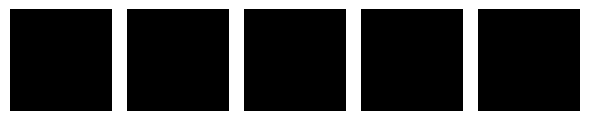

Epoch: 1 -- Generator Loss: 8.927759170532227, Discriminator Loss: 0.030694449320435524

Took 26.12622046470642 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

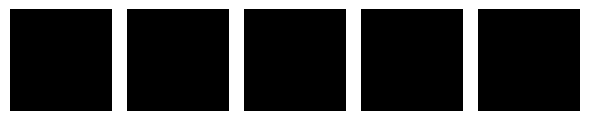

Epoch: 2 -- Generator Loss: 11.832780838012695, Discriminator Loss: 2.206012504757382e-05

Took 12.98786997795105 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

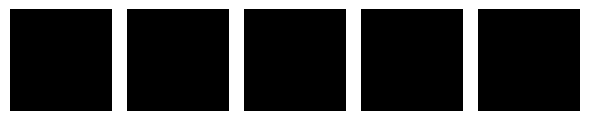

Epoch: 3 -- Generator Loss: 12.71242618560791, Discriminator Loss: 6.651991043327143e-06

Took 12.974703073501587 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

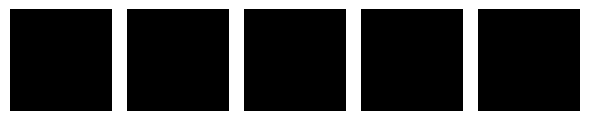

Epoch: 4 -- Generator Loss: 13.413533210754395, Discriminator Loss: 3.2750247100921115e-06

Took 13.19357705116272 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

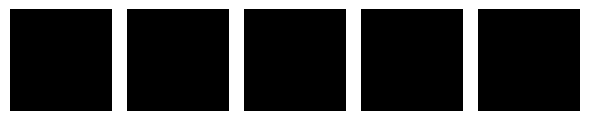

Epoch: 5 -- Generator Loss: 13.945523262023926, Discriminator Loss: 2.045728251687251e-06

Took 13.523689031600952 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

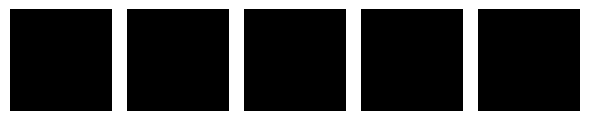

Epoch: 6 -- Generator Loss: 14.295636177062988, Discriminator Loss: 1.2593383189596352e-06

Took 13.848411798477173 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

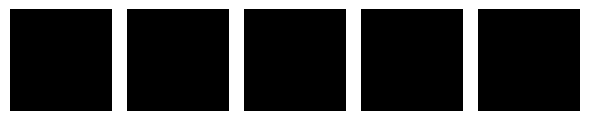

Epoch: 7 -- Generator Loss: 14.720051765441895, Discriminator Loss: 8.750503184273839e-07

Took 14.077608823776245 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

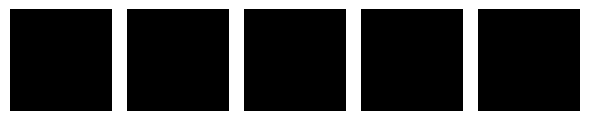

Epoch: 8 -- Generator Loss: 15.109375953674316, Discriminator Loss: 5.917610792494088e-07

Took 13.345905303955078 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

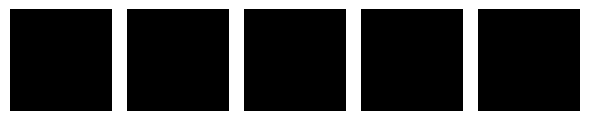

Epoch: 9 -- Generator Loss: 15.40721607208252, Discriminator Loss: 4.3680057615347323e-07

Took 13.305795192718506 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

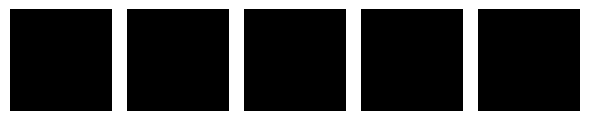

Epoch: 10 -- Generator Loss: 15.713786125183105, Discriminator Loss: 3.0251274552028917e-07

Took 13.291515827178955 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

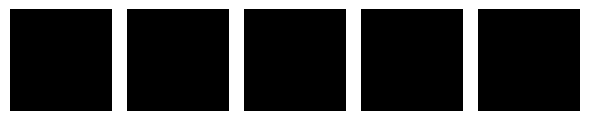

Epoch: 11 -- Generator Loss: 16.07583999633789, Discriminator Loss: 2.263151372972061e-07

Took 13.338486194610596 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

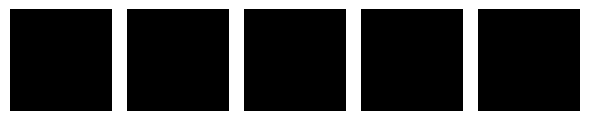

Epoch: 12 -- Generator Loss: 16.391489028930664, Discriminator Loss: 1.6637058308788255e-07

Took 13.371058940887451 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

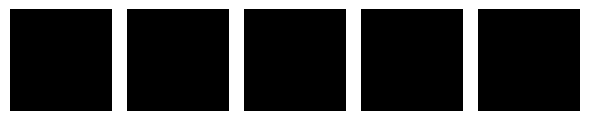

Epoch: 13 -- Generator Loss: 16.62322998046875, Discriminator Loss: 1.245722955900419e-07

Took 13.368680477142334 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

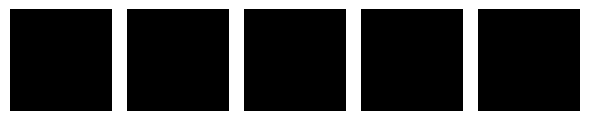

Epoch: 14 -- Generator Loss: 16.915597915649414, Discriminator Loss: 1.0046395715335166e-07

Took 13.588290452957153 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

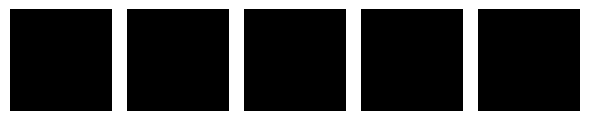

Epoch: 15 -- Generator Loss: 17.25444793701172, Discriminator Loss: 7.042872596230154e-08

Took 13.350476741790771 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

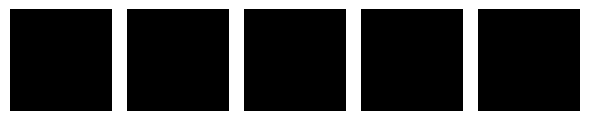

Epoch: 16 -- Generator Loss: 17.462045669555664, Discriminator Loss: 5.856922413727261e-08

Took 13.319309711456299 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

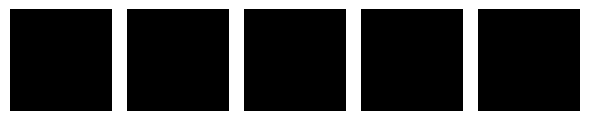

Epoch: 17 -- Generator Loss: 17.709768295288086, Discriminator Loss: 4.3284959616585184e-08

Took 13.449092388153076 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

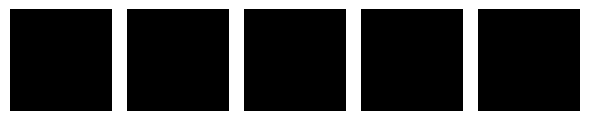

Epoch: 18 -- Generator Loss: 17.939342498779297, Discriminator Loss: 3.388823444083755e-08

Took 13.565443515777588 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

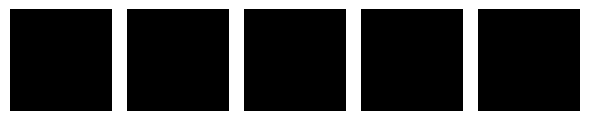

Epoch: 19 -- Generator Loss: 18.23189353942871, Discriminator Loss: 2.5586405882904728e-08

Took 13.40260934829712 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

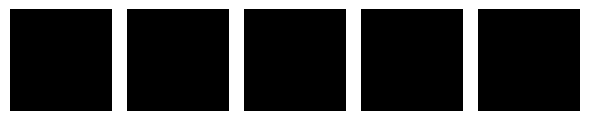

Epoch: 20 -- Generator Loss: 18.505023956298828, Discriminator Loss: 1.9403202600187797e-08

Took 13.321901798248291 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

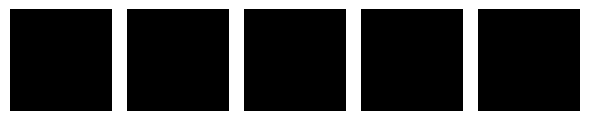

Epoch: 21 -- Generator Loss: 18.781068801879883, Discriminator Loss: 1.5215652737765595e-08

Took 13.328886032104492 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

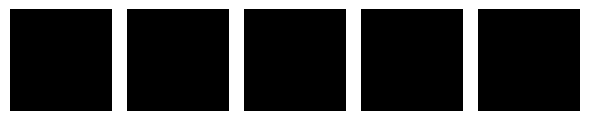

Epoch: 22 -- Generator Loss: 19.002492904663086, Discriminator Loss: 1.2094350410052357e-08

Took 13.329387187957764 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

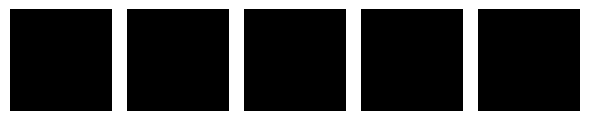

Epoch: 23 -- Generator Loss: 19.225566864013672, Discriminator Loss: 9.462156391748522e-09

Took 13.319680213928223 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

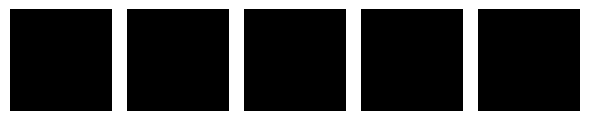

Epoch: 24 -- Generator Loss: 19.506994247436523, Discriminator Loss: 7.707851246152586e-09

Took 13.34971284866333 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

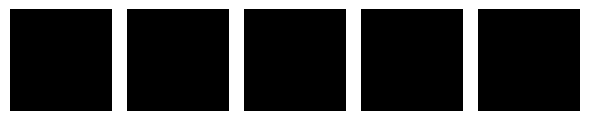

Epoch: 25 -- Generator Loss: 19.734392166137695, Discriminator Loss: 6.001077856865322e-09

Took 13.31725287437439 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

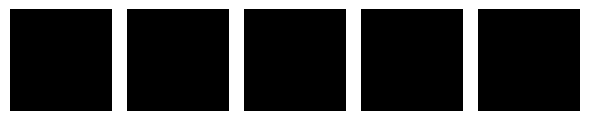

Epoch: 26 -- Generator Loss: 19.986207962036133, Discriminator Loss: 4.5801296089109655e-09

Took 13.595525741577148 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

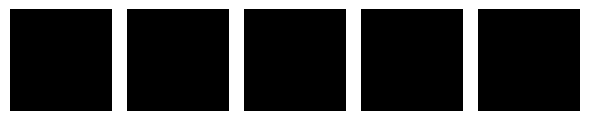

Epoch: 27 -- Generator Loss: 20.21930694580078, Discriminator Loss: 3.751469801471785e-09

Took 13.333532333374023 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

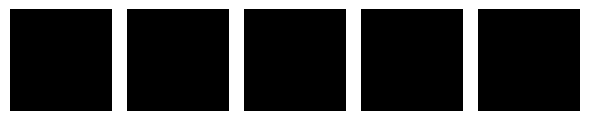

Epoch: 28 -- Generator Loss: 20.37948226928711, Discriminator Loss: 2.976086266315292e-09

Took 13.32230520248413 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

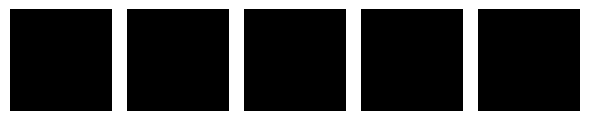

Epoch: 29 -- Generator Loss: 20.652631759643555, Discriminator Loss: 2.435410095813495e-09

Took 13.483917474746704 seconds. 




  0%|          | 0/468 [00:00<?, ?it/s]

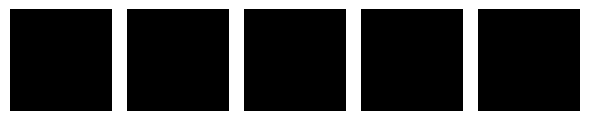

Epoch: 30 -- Generator Loss: 20.844816207885742, Discriminator Loss: 1.965681839521949e-09

Took 13.453063726425171 seconds. 




In [17]:
train(train_dataset, 30)